In [1]:
from transformer import *
from plotting import *
import os

device is  cuda


In [2]:
import pandas as pd
import torch
from torch import nn, Tensor
from torch.utils.data import dataset, DataLoader
from torchvision import transforms

from PIL import Image

class TrajDataset(dataset.Dataset):

    to_tensor = transforms.ToTensor()
    # cols = ["track_id", "xmin", "ymin", "xmax", "ymax", "frame", "lost", "occluded", "generated", "label"]

    def __init__(self, data_folder, n_prev=4, n_next=6, img_step=10, n_traj = 10, device=None):
        self.data_folder = data_folder
        self.n_prev = n_prev
        self.n_next = n_next
        self.img_step = img_step
        self.n_traj = n_traj

        self.src = Tensor()
        self.intermediate = Tensor()
        self.tgt = Tensor()
        self.process_data()
        self.device = device

    def process_data(self):
        raw_data = pd.read_csv(self.data_folder + "/annotations_" + str(self.img_step) + ".txt", sep=" ")
        #print(raw_data)
        #raw_data = raw_data[raw_data.index % self.img_step == 0]
        src = []
        intermediate = []
        tgt = []

        track_ids = raw_data["track_id"].unique()[:self.n_traj]
        e
        for track_id in track_ids:
            print("opening track " + str(track_id))
            traj = raw_data[raw_data["track_id"] == track_id]  # get all positions of track
            memo = {}
            for i in range(len(traj) - self.n_next - self.n_prev):
                # n_prev images used to predict
                x = self.get_n_images_after_i(traj, self.n_prev, i, memo)
                src.append(x)
                # images that should be predicted
                x2 = self.get_n_images_after_i(traj, self.n_next, self.n_prev + i, memo)
                intermediate.append(x2)
                # bounding boxes inside predicted images
                y = traj.iloc[i + self.n_prev: i + self.n_prev + self.n_next][["xmin", "ymin", "xmax", "ymax"]]  # recuperer le grand truth à prédire
                tgt.append(Tensor(y.values)) # add to ground truth dataset

        self.src = torch.stack(src, dim=0)
        self.intermediate = torch.stack(intermediate, dim=0)
        self.tgt = torch.stack(tgt, dim=0)

    def normalize_img(self, img):
        return img / img.norm(p=2)

    def normalize_coords(self,df):
        return (df-df.min())/(df.max()-df.min())

    def get_n_images_after_i(self, traj, n, i, memo):
        X = []
        for ind, pos in traj.iloc[i: i+n,:].iterrows():
            track_id = pos["track_id"]
            frame = pos["frame"]
            path = f"{self.data_folder}/{track_id:03d}_{frame:05d}.jpg"
            if path in memo:
                img = memo[path]
            else:
                img = Image.open(f"{self.data_folder}/{track_id:03d}_{frame:05d}.jpg")
                memo[path] = img
            img_tensor = self.to_tensor(img)
            X.append(img_tensor)
        return torch.cat(X)

    def __getitem__(self, item):
        src = self.src[item]
        intermediate = self.intermediate[item]
        tgt = self.tgt[item]
        return {"src": src, "intermediate": intermediate, "tgt": tgt}

    def __len__(self):
        return len(self.src)

    def get_image_size(self):
        return self.src[0].size()[1:]

    def get_dataset_infos(self):
        return {"image_size":self.get_image_size(),
                "n_prev": self.n_prev,
                "n_next": self.n_next}


In [62]:
data_folder = "datasets/bookstore/video0/64_64_8"
train_dataset = TrajDataset(data_folder, n_prev=8, n_next=2, n_traj=1)
dataset_infos = train_dataset.get_dataset_infos()
print(dataset_infos["image_size"])
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

opening track 0
torch.Size([64, 64])


In [63]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print("device is ", device)

device is  cuda:1


In [64]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, \
    TransformerDecoderLayer
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, RMSprop
from traj_dataset import TrajDataset

from einops import rearrange
from einops.layers.torch import Rearrange

from plotting import *


def pair(t):
    return t if isinstance(t, tuple) else (t, t)


def posemb_sincos_3d(patches, temperature=10000, dtype=torch.float32):
    _, f, h, w, dim, dtype = *patches.shape, patches.dtype

    x, y, z = torch.meshgrid(
        torch.arange(f, device=device),
        torch.arange(h, device=device),
        torch.arange(w, device=device),
        indexing='ij')

    fourier_dim = dim // 6

    omega = torch.arange(fourier_dim, device=device) / (fourier_dim - 1)
    omega = 1. / (temperature ** omega)

    z = z.flatten()[:, None] * omega[None, :]
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]

    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos(), z.sin(), z.cos()), dim=1)

    pe = F.pad(pe, (0, dim - (fourier_dim * 6)))  # pad if feature dimension not cleanly divisible by 6
    return pe.type(dtype)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, out_dim=None):
        super().__init__()
        self.net = nn.Sequential(
            # nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim if out_dim else dim),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)


class TrajVit(nn.Module):

    def __init__(self, d_model, dataset_infos, image_patch_size=(8, 8), frame_patch_size=4, n_heads=8,
                 n_layers=6,
                 mlp_dim=512, channels=1, batch_first=True):
        super(TrajVit, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.model_type = 'TrajVit'
        self.device = device
        self.dataset_infos = dataset_infos
        
        n_next = dataset_infos["n_next"]
        
        # images and patches infos
        frames = dataset_infos["n_prev"]
        image_size = dataset_infos["image_size"]
        self.image_size = image_size
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(image_patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        assert frames % frame_patch_size == 0, 'Frames must be divisible by the frame patch size'

        self.sos = torch.ones(image_size, device=device).unsqueeze(0)

        num_patches = (image_height // patch_height) * (image_width // patch_width) * (frames // frame_patch_size)
        patch_dim = channels * patch_height * patch_width * frame_patch_size

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b (f pf) (h p1) (w p2) -> b f h w (p1 p2 pf)', p1=patch_height, p2=patch_width,
                      pf=frame_patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, d_model),
            nn.LayerNorm(d_model),
        ).to(self.device)

        # normalization
        self.normalisation = nn.Identity(device=device)
        
        self.coord_to_img_layer = nn.Linear(8, n_next*image_height*image_width).to(device=device)

        # encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, batch_first=batch_first, device=device)
        self.encoder = TransformerEncoder(encoder_layer, n_layers)

        # decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model, n_heads, batch_first=batch_first, device=device)
        self.decoder = TransformerDecoder(decoder_layer, n_layers)

        # inv normalization

        # MLP for regression
        num_patch_future = (image_height // patch_height) * (image_width // patch_width) * (dataset_infos['n_next'] // frame_patch_size)
        input_mlp = num_patch_future * d_model
        self.mlp = FeedForward(input_mlp, mlp_dim, n_next * 4).to(device=device)
        return
    
    def coord_to_img(self, tgt):
        x = torch.flatten(tgt, 1)
        x = self.coord_to_img_layer(x)
        return x.view(-1, self.dataset_infos["n_next"], *self.image_size)
    
    def train_forward(self, src, tgt):
        batch_size, n_prev, h, w, dtype = *src.shape, src.dtype
        batch_size2, n_next, coords = tgt.shape
        assert batch_size == batch_size2
        
        src = src.to(self.device)
        tgt = tgt.to(self.device)
        

        src_e = self.to_patch_embedding(src).to(self.device)
        src_pe = posemb_sincos_3d(src_e)
        src_e = rearrange(src_e, 'b ... d -> b (...) d') + src_pe

        tgt_img = self.coord_to_img(tgt)
        
        tgt_e = self.to_patch_embedding(tgt_img).to(self.device)
        tgt_pe = posemb_sincos_3d(tgt_e)
        tgt_e = rearrange(tgt_e, 'b ... d -> b (...) d') + tgt_pe
        
        x = self.encoder(src_e)

        #tgt_mask = torch.triu(torch.full((itm_e.size()[1], itm_e.size()[1]), float('-inf'))).to(device=self.device)
        #tgt_mask = torch.ones((x.size()[1], x.size()[1])).to(device=self.device)
        tgt_mask = Transformer.generate_square_subsequent_mask(tgt_e.size()[1]).to(device=self.device)
        
        x = self.decoder(tgt_e, x, tgt_mask=tgt_mask)
        x = self.mlp(x)
        x = x.view((batch_size, -1, 4))
        return x
    
    def test_forward(self, src):
        batch_size, _, h, w, dtype = *src.shape, src.dtype
        n_next = self.dataset_infos['n_next']
        
        sos = self.sos.repeat(batch_size, n_next, 1, 1)
        print(sos.size())
        
        src = src.to(self.device)
        
        src_e = self.to_patch_embedding(src).to(self.device)
        src_pe = posemb_sincos_3d(src_e)
        src_e = rearrange(src_e, 'b ... d -> b (...) d') + src_pe
        
        sos_e = self.to_patch_embedding(sos).to(self.device)
        sos_pe = posemb_sincos_3d(sos_e)
        sos_e = rearrange(sos_e, 'b ... d -> b (...) d') + sos_pe

        x = self.encoder(src_e)
        tgt_mask = Transformer.generate_square_subsequent_mask(sos.size()[1]).to(device=self.device)
        
        x = self.decoder(sos, x, tgt_mask=tgt_mask)
        x = self.mlp(x)
        print(x.size())
        x = x.view((batch_size, -1, 4))
        return x

    def forward(self, src, tgt=None):
        if tgt == None:
            return self.test_forward(src)
        return self.train_forward(src, tgt)

starting epoch:  0
tensor(0.1157, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(5.1574, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(58.2255, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(62.5397, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(40.1494, device='cuda:1', grad_fn=<SelectBackward0>)
starting epoch:  1
tensor(9.8409, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(-0.9483, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(-0.9004, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(0.5912, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(2.3897, device='cuda:1', grad_fn=<SelectBackward0>)
starting epoch:  2
tensor(4.1441, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(8.3162, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(12.3224, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(15.4810, device='cuda:1', grad_fn=<SelectBackward0>)
tensor(17.3085, device='cuda:1', grad_fn=<SelectBackward0>)
starting epoch:  3
tensor(18.1994, device='cuda:1'

mkdir: cannot create directory ‘plots’: File exists


100


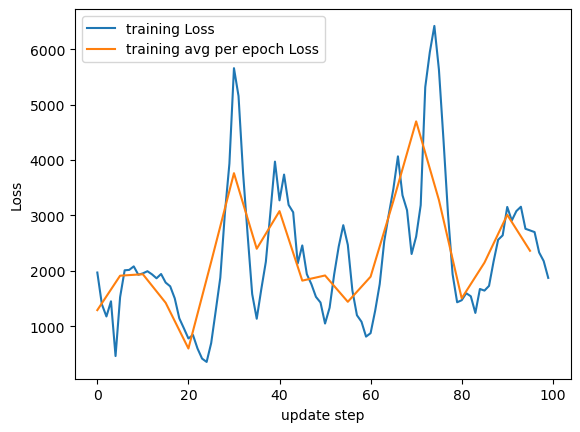

In [71]:
model = TrajVit(512, dataset_infos, image_patch_size=(8, 8), frame_patch_size=2)
optim = Adam(params=model.parameters(), lr=0.001)
criterion = nn.MSELoss()

loss_evol = []
n_epochs = 20
# Should add epochs
model.train()
for epoch in range(n_epochs):
    print("starting epoch: ", epoch)
    epoch_loss = []
    for id_b, batch in enumerate(train_loader):
        src = batch['src'].to(device=device)
        #itm = batch['intermediate'].to(device=device)
        tgt = batch['tgt'].to(device=device)
        pred = model(src, tgt)
        print(pred[0][0][0])
        loss = criterion(pred, tgt)
        epoch_loss.append(loss.item())
        loss.backward()
        optim.step()

    loss_evol.append(epoch_loss)
    

plot_losses(loss_evol)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
annot = pd.read_csv(data_folder + "/annotations_10.txt", sep=" ") 

In [ ]:
model.eval()
optim.zero_grad()
for id_b, batch in enumerate(train_loader):
    src = batch['src'].to(device=device)
    tgt = batch['tgt'].to(device=device)
    pred = model(src)
    break
    #print("true: ", tgt)

    
print("\n\n\n")
model.eval()
optim.zero_grad()
for id_b, batch in enumerate(train_loader):
    src = batch['src'].to(device=device)
    tgt = batch['tgt'].to(device=device)
    pred = model(src)
    break
    #print("true: ", tgt)


In [ ]:
reference_image = "reference_64_64.gif"
image = plt.imread(reference_image)
fig, ax = plt.subplots()

print(prediction)
ax.scatter(annot.x[:20], annot.y[:20], color="red")
#ax.scatter(pred.x[:20], pred.y[:20], color="blue")
ax.imshow(image)